# Assignment 2 - Recurrent Neural Network Dynamics 

This coursework is a study of how well a recurrent network model of primary visual cortex (V1) can represent specific features (we will use the example of orientation) of a brief visual stimulus, in the face of readout noise, depending on its connectivity.

We will begin with the experimental set up:

## Technical Set Up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit



## Experimental Set Up

### Default Parameters

In [105]:
tau = 20 # characteristic neuron time constant (in ms)

m = 200 # number of regularly spaced orientations

n = 200 # number of neuronal inputs

B = np.eye(m,n) # feedforward input weights

C = np.eye(m,n) # matrix of output weights

sigma = 1 # noise of readout activity 

k = np.pi/4 # encoder constant

alpha = 0.9 # recurrent connection strength constant 1

alpha_prime = 0.9 # recurrent connection strength constant 2

phi = 2 * np.pi * np.linspace(0,1,m) # grid of regularly spaced parameters

dt = 1 # timestep (in ms)

### Default Functions

In [142]:
# Tuning Function
def V(z):
    return np.exp( (np.cos(z)-1) * k**(-2))


# Input Encoding Function
def h(phi, theta):
    return V(phi-theta)


# Euler Method Update Function - this is an el classico
def update_r(r_t, t, W, B, h_theta, tau, dt):

    #  r(t+1) = r(t) + dt * (dr/dt)

    if t == 0:
        r = (dt/tau) * (B@h_theta)

    else:
        dr_dt = (1/tau) * (W - np.eye(W.shape[0])) @ r_t 
        r = r_t + dt * dr_dt

    return r 


# Noisy Readout of V1 Activity
def o_tilde_func(C, r_t, sigma):
    noise = np.random.normal(0,1, size = C.shape[0])
    return C @ r_t + sigma * noise 


# Noisy Readout data
def theta_hat_func(phi, o_tilde):

    x = np.sum(o_tilde * np.sin(phi))
    y = np.sum(o_tilde * np.cos(phi))
    
    # Return decoded orientation in [0, 2π)
    return np.arctan2(x,y)


def circ_dist(theta_hat, theta):
    # Circular distance in radians [0, π]
    return np.arccos(np.cos(theta_hat - theta))


# Rescale matrix W_raq to the spectral radius equals alpha
def R(W_raw, alpha):
    eigvals = np.linalg.eigvals(W_raw)
    spectral_radius = np.max(np.abs(eigvals))
    return (alpha / spectral_radius) * W_raw

## Simulation Function 

In [180]:
def run_simulation(theta, phi, time_steps, W, B, C, tau, dt):

    np.random.seed(42069)

    # --- Main simulation ---

    # Vector: V(phi-theta), where phi is the grid of regularly spaced points, and theta is the input orientation
    # The V function is a Von-Mises distribution, commonly used to model data measured on a circle (e.g. orientation)
    h_model = h(phi, theta)

    # Vector: the ith element of this vector represents the momentary firing rate of V1 neuron i 
    r_list = [0] # added a dummy value at the start so by code doesn't f*ck up 

    # for each time step
    for i, time in enumerate(time_steps):

        # r = update r given the previous one
        r = update_r(r_list[i], time, W, B, h_model, tau, dt)

        r_list.append(r) # appending r to my list

    r_list = r_list[1:] # getting rid of dummy value - is this optimal coding 😳

    return r_list


## Decoding Function

In [198]:
def decoding_error_func(r_list, C, sigma, phi, theta):

    decoding_error_list = []

    for r in r_list: # r is a vector size n!

        noise = np.random.normal(0,1, size = C.shape[0])

        o_tilde = C @ r + sigma * noise 

        x = np.sum(o_tilde * np.sin(phi))
        y = np.sum(o_tilde * np.cos(phi))
        
        theta_hat =  np.arctan2(x,y)

        decoding_error = np.arccos(np.cos(theta_hat-theta))

        decoding_error_list.append(decoding_error)

    return decoding_error_list

## Questions and Experiments

### Question 1 - Integrating the Dynamics of the 4 different Models

#### Model 1: No Recurrence

In [231]:
m = 200
n = 200
time_steps = np.linspace(0,60,100)
theta = np.pi
W_1 = np.zeros((m,n))

# Run the simulation
r_list_w1 = run_simulation(
    theta = np.pi, 
    phi = 2 * np.pi * np.linspace(0,1,m),
    time_steps = np.linspace(0,60,100), 
    W = W_1,
    B = np.eye(m),
    C = np.eye(m), 
    tau = 20, 
    dt = 1, 
)

# Find the decoding error
decoding_error_w1 = decoding_error_func(
    r_list = r_list_w1, 
    C = np.eye(m), 
    sigma = 1, 
    phi = 2 * np.pi * np.linspace(0,1,m), 
    theta = np.pi)


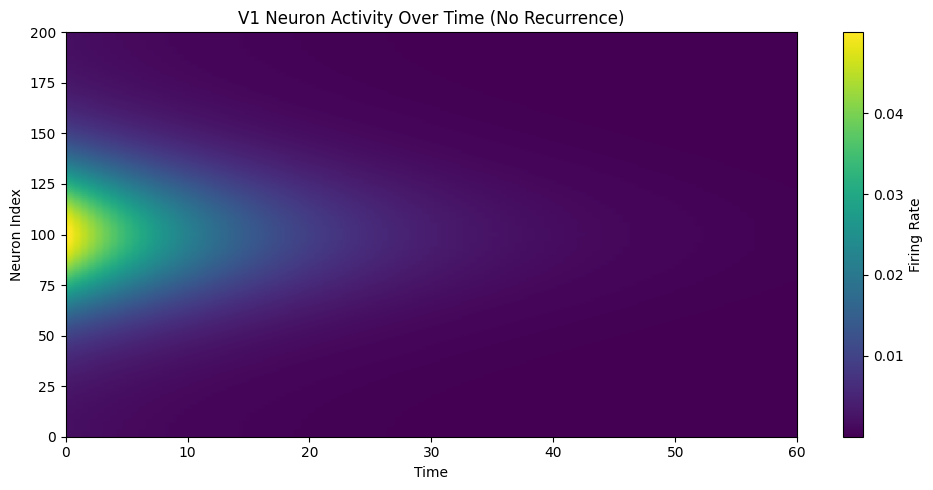

In [232]:
r_mat = np.array(r_list_w1)  # shape: (timesteps, neurons)

plt.figure(figsize=(10, 5))
plt.imshow(r_mat.T, aspect='auto', cmap='viridis', origin='lower',
           extent=[time_steps[0], time_steps[-1], 0, r_mat.shape[1]])
plt.colorbar(label='Firing Rate')
plt.xlabel('Time')
plt.ylabel('Neuron Index')
plt.title('V1 Neuron Activity Over Time (No Recurrence)')
plt.tight_layout()
plt.show()


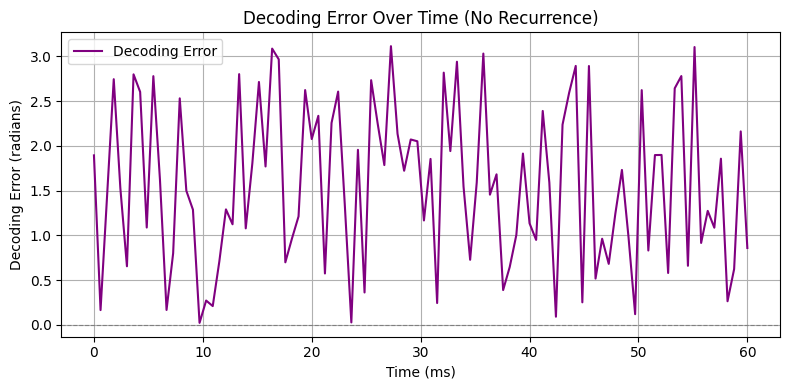

In [233]:
# Plot
plt.figure(figsize=(8, 4))
plt.plot(time_steps, decoding_error_w1, label='Decoding Error', color='purple')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel('Time (ms)')
plt.ylabel('Decoding Error (radians)')
plt.title('Decoding Error Over Time (No Recurrence)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

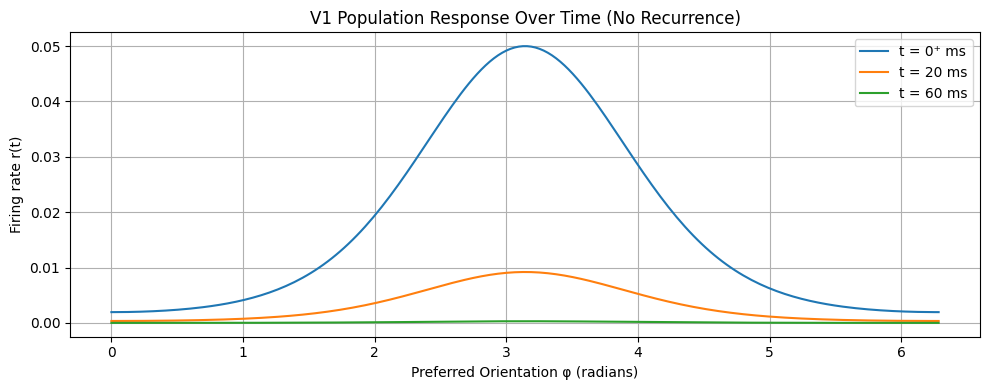

In [234]:
# Convert time steps to indices
idx_0p = 0
idx_20 = np.argmin(np.abs(time_steps - 20))
idx_60 = np.argmin(np.abs(time_steps - 60))

# Extract r(t) vectors
r_0p = r_list_w1[idx_0p]
r_20 = r_list_w1[idx_20]
r_60 = r_list_w1[idx_60]

phi = 2 * np.pi * np.linspace(0, 1, m)  # match your code

plt.figure(figsize=(10, 4))
plt.plot(phi, r_0p, label='t = 0⁺ ms')
plt.plot(phi, r_20, label='t = 20 ms')
plt.plot(phi, r_60, label='t = 60 ms')
plt.xlabel('Preferred Orientation φ (radians)')
plt.ylabel('Firing rate r(t)')
plt.title('V1 Population Response Over Time (No Recurrence)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Model 2: Random Symmetric Connectivity

In [235]:
# Model 2: Random symmetric connectivity
W_tilde = np.random.normal(0, 1, size=B.shape)
W_2 = R(W_tilde + W_tilde.T, alpha)

m = 200
n = 200
time_steps = np.linspace(0,60,100)
theta = np.pi

# Run the simulation
r_list_w2 = run_simulation(
    theta = np.pi, 
    phi = 2 * np.pi * np.linspace(0,1,m),
    time_steps = np.linspace(0,60,100), 
    W = W_2,
    B = np.eye(m),
    C = np.eye(m), 
    tau = 20, 
    dt = 1, 
)

# Find the decoding error
decoding_error_w2 = decoding_error_func(
    r_list = r_list_w2, 
    C = np.eye(m), 
    sigma = 1, 
    phi = 2 * np.pi * np.linspace(0,1,m), 
    theta = np.pi)

##### Plotting

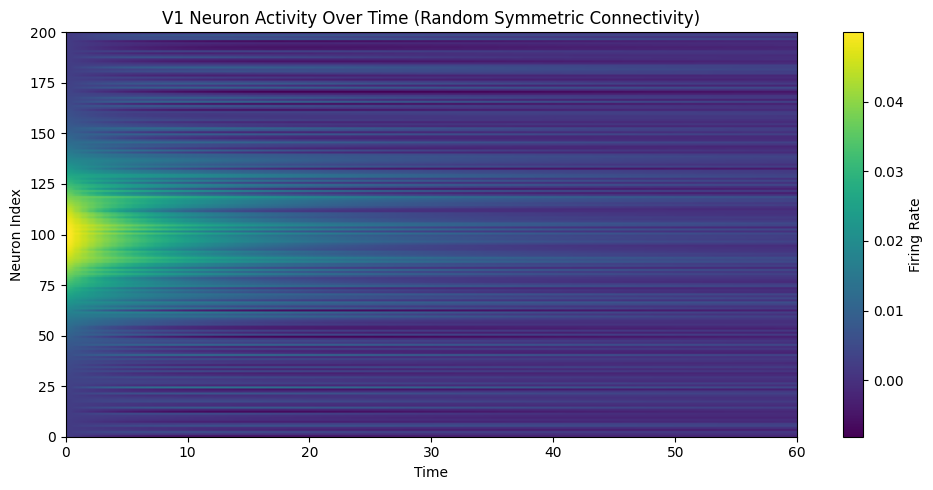

In [236]:
r_mat_w2 = np.array(r_list_w2)  # shape: (timesteps, neurons)

plt.figure(figsize=(10, 5))
plt.imshow(r_mat_w2.T, aspect='auto', cmap='viridis', origin='lower',
           extent=[time_steps[0], time_steps[-1], 0, r_mat.shape[1]])
plt.colorbar(label='Firing Rate')
plt.xlabel('Time')
plt.ylabel('Neuron Index')
plt.title('V1 Neuron Activity Over Time (Random Symmetric Connectivity)')
plt.tight_layout()
plt.show()


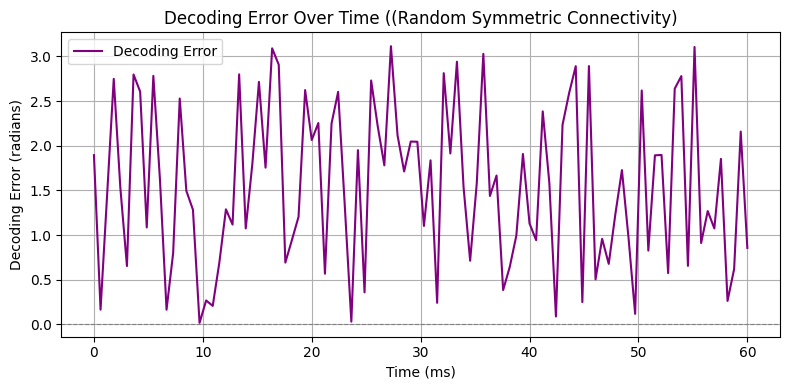

In [237]:
# Plot
plt.figure(figsize=(8, 4))
plt.plot(time_steps, decoding_error_w2, label='Decoding Error', color='purple')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel('Time (ms)')
plt.ylabel('Decoding Error (radians)')
plt.title('Decoding Error Over Time ((Random Symmetric Connectivity)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

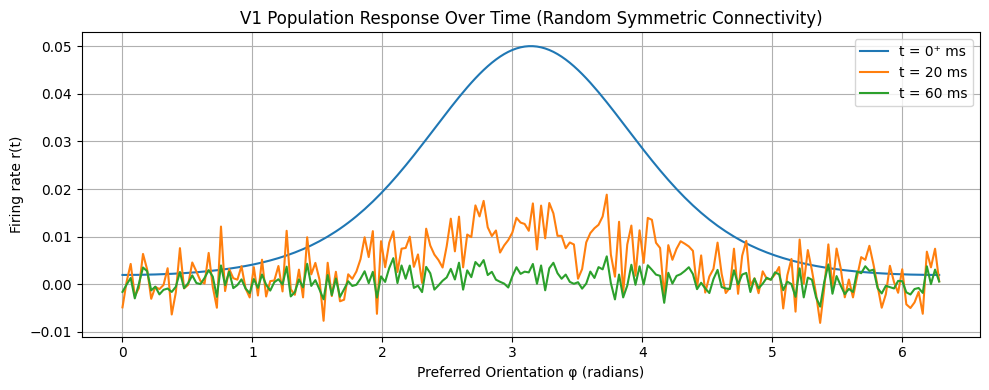

In [238]:
# Convert time steps to indices
idx_0p = 0
idx_20 = np.argmin(np.abs(time_steps - 20))
idx_60 = np.argmin(np.abs(time_steps - 60))

# Extract r(t) vectors
r_0p = r_list_w2[idx_0p]
r_20 = r_list_w2[idx_20]
r_60 = r_list_w2[idx_60]

phi = 2 * np.pi * np.linspace(0, 1, m)  # match your code

plt.figure(figsize=(10, 4))
plt.plot(phi, r_0p, label='t = 0⁺ ms')
plt.plot(phi, r_20, label='t = 20 ms')
plt.plot(phi, r_60, label='t = 60 ms')
plt.xlabel('Preferred Orientation φ (radians)')
plt.ylabel('Firing rate r(t)')
plt.title('V1 Population Response Over Time (Random Symmetric Connectivity)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [242]:
print(np.linalg.norm(np.array(r_list_w1) - np.array(r_list_w2)))
print(np.linalg.norm(np.array(decoding_error_w1) - np.array(decoding_error_w2)))


0.4960963049322935
0.14861102835407775


So the above shows that these in fact ARE changing - but just not very much! Hence, the recurrence isn't strong or directional enough. The stimulus is brief and noise masks the effect!

#### Model 3: Symmetric Ring Structure

In [243]:
W_ij = np.zeros_like(B)
for i in range(n):
    for j in range(n):
        W_ij[i,j] = V(phi[i]-phi[j])

W_3 = R(W_ij, alpha)


# Run the simulation
r_list_w3 = run_simulation(
    theta = np.pi, 
    phi = 2 * np.pi * np.linspace(0,1,m),
    time_steps = np.linspace(0,60,100), 
    W = W_3,
    B = np.eye(m),
    C = np.eye(m), 
    tau = 20, 
    dt = 1, 
)

# Find the decoding error
decoding_error_w3 = decoding_error_func(
    r_list = r_list_w3, 
    C = np.eye(m), 
    sigma = 1, 
    phi = 2 * np.pi * np.linspace(0,1,m), 
    theta = np.pi)


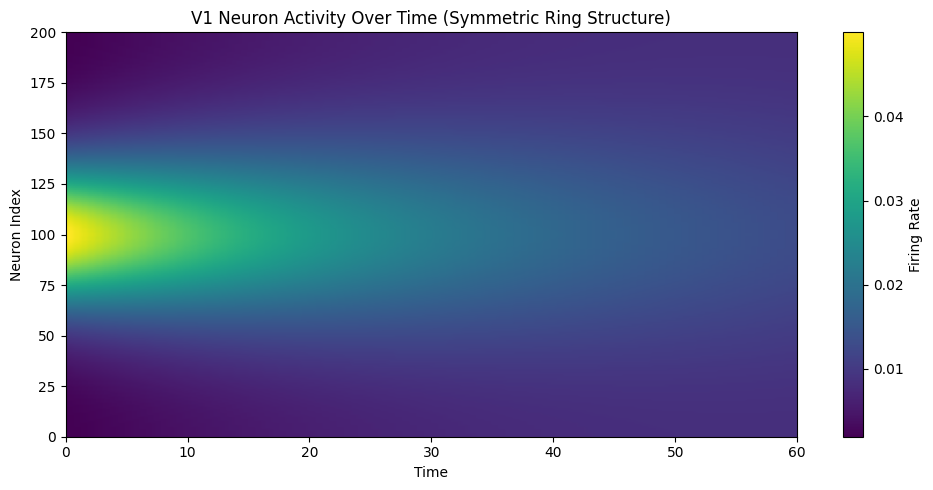

In [244]:
r_mat_w3 = np.array(r_list_w3)  # shape: (timesteps, neurons)

plt.figure(figsize=(10, 5))
plt.imshow(r_mat_w3.T, aspect='auto', cmap='viridis', origin='lower',
           extent=[time_steps[0], time_steps[-1], 0, r_mat_w3.shape[1]])
plt.colorbar(label='Firing Rate')
plt.xlabel('Time')
plt.ylabel('Neuron Index')
plt.title('V1 Neuron Activity Over Time (Symmetric Ring Structure)')
plt.tight_layout()
plt.show()


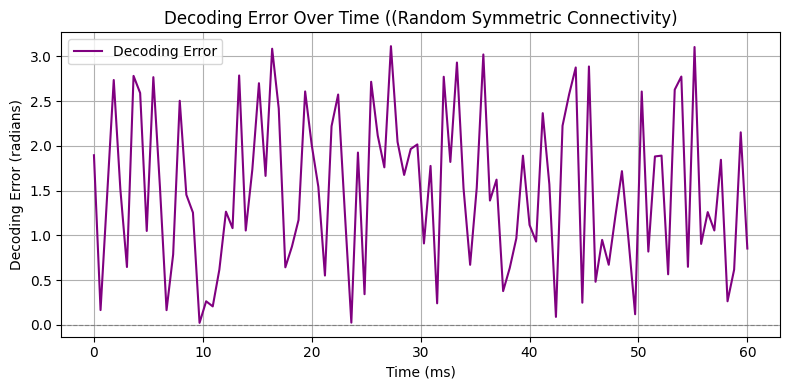

In [245]:
# Plot
plt.figure(figsize=(8, 4))
plt.plot(time_steps, decoding_error_w3, label='Decoding Error', color='purple')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel('Time (ms)')
plt.ylabel('Decoding Error (radians)')
plt.title('Decoding Error Over Time ((Random Symmetric Connectivity)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

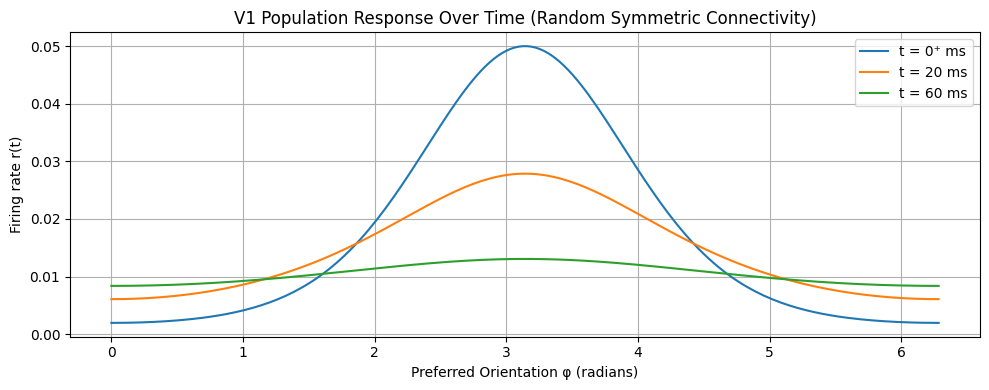

In [246]:
# Convert time steps to indices
idx_0p = 0
idx_20 = np.argmin(np.abs(time_steps - 20))
idx_60 = np.argmin(np.abs(time_steps - 60))

# Extract r(t) vectors
r_0p = r_list_w3[idx_0p]
r_20 = r_list_w3[idx_20]
r_60 = r_list_w3[idx_60]

phi = 2 * np.pi * np.linspace(0, 1, m)  # match your code

plt.figure(figsize=(10, 4))
plt.plot(phi, r_0p, label='t = 0⁺ ms')
plt.plot(phi, r_20, label='t = 20 ms')
plt.plot(phi, r_60, label='t = 60 ms')
plt.xlabel('Preferred Orientation φ (radians)')
plt.ylabel('Firing rate r(t)')
plt.title('V1 Population Response Over Time (Random Symmetric Connectivity)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Question 2: Investigations into Model 2

We begin by investigating the variance against time for all 4 fitted models, presuming that at each discretised time step we can fit a Gaussian. We then measure the "noise" as the difference between the actual activity and the fitted Gaussian: the residual. We then compute the standard deviation of the residuals for each model over time - thus capturing irregularities and small-scale noise.

In [11]:
def gaussian(x, A, mu, sigma, baseline):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + baseline

def fit_gaussians_over_time(r_array, phi):
    r_array = np.array(r_array[:-1])
    sigma_list = []
    residual_std_list = []

    for r_t in r_array:
        try:
            A0 = np.max(r_t)
            mu0 = phi[np.argmax(r_t)]
            sigma0 = 0.5
            baseline0 = np.min(r_t)
            popt, _ = curve_fit(gaussian, phi, r_t, p0=[A0, mu0, sigma0, baseline0])
            fitted = gaussian(phi, *popt)
            residuals = r_t - fitted
            sigma_list.append(popt[2])
            residual_std_list.append(np.std(residuals))
        except RuntimeError:
            sigma_list.append(np.nan)
            residual_std_list.append(np.nan)

    return np.array(sigma_list), np.array(residual_std_list)


/var/folders/8m/mlfdjz4d5bd1hd67c6nkhb_00000gn/T/ipykernel_89241/335916710.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian, phi, r_t, p0=[A0, mu0, sigma0, baseline0])


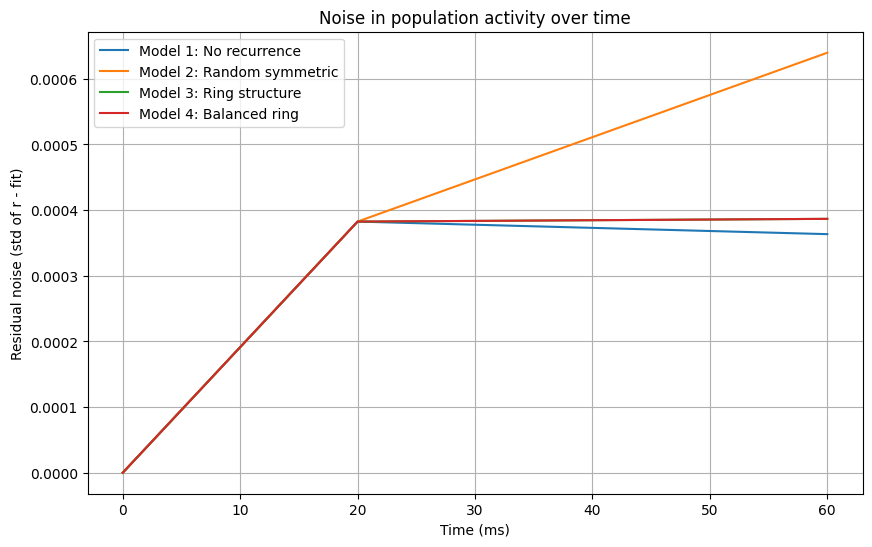

In [12]:
sigma_t_1, resid_t_1 = fit_gaussians_over_time(r_list_w1, phi)
sigma_t_2, resid_t_2 = fit_gaussians_over_time(r_list_w2, phi)
sigma_t_3, resid_t_3 = fit_gaussians_over_time(r_list_w3, phi)
sigma_t_4, resid_t_4 = fit_gaussians_over_time([r[:len(phi)] for r in r_list_w4], phi)

plt.figure(figsize=(10, 6))
plt.plot(time_steps, resid_t_1, label="Model 1: No recurrence")
plt.plot(time_steps, resid_t_2, label="Model 2: Random symmetric")
plt.plot(time_steps, resid_t_3, label="Model 3: Ring structure")
plt.plot(time_steps, resid_t_4, label="Model 4: Balanced ring")

plt.xlabel("Time (ms)")
plt.ylabel("Residual noise (std of r - fit)")
plt.title("Noise in population activity over time")
plt.legend()
plt.grid(True)
plt.show()



### 🧮 Eigendecomposition of the Recurrent Dynamics

The post-input dynamics of the network are governed by:

$$
\frac{dr(t)}{dt} = -r(t) + W r(t)
$$

Define the effective dynamics matrix:

$$
A := -I + W
$$

If $A \in \mathbb{R}^{m \times m}$ is diagonalizable, we can write:

$$
A = Q \Lambda Q^{-1}
$$

Where:
- $Q$ contains the eigenvectors of $A$
- $\Lambda$ is a diagonal matrix of eigenvalues $\lambda_1, \dots, \lambda_m$

If $W$ is **symmetric** (as in Model 2), then:
- $Q$ is orthogonal: $Q^{-1} = Q^\top$
- So:

$$
A = Q \Lambda Q^\top
$$

The solution to the dynamics becomes:

$$
r(t) = Q \, e^{\Lambda t} \, Q^\top r(0)
$$

Each eigenmode $q_i$ evolves as:

$$
r_i(t) = e^{\lambda_i t} \langle q_i, r(0) \rangle
$$

---

### 💡 Interpretation for Model 2

In Model 2:
- $W$ is based on a **random symmetric matrix**, so its eigenvectors are not aligned with the input bump
- Even though the spectral radius is normalised, **noisy eigenmodes** can be amplified
- The dynamics can evolve in irregular directions, producing **greater residual noise** and **less structured responses**

This explains the **growing deviation from smooth Gaussian profiles** in Model 2's activity, as observed in the residual error plots.


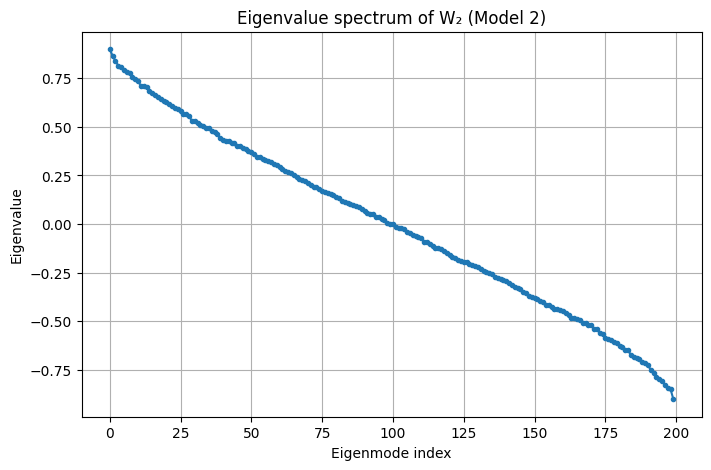

In [97]:
eigvals, eigvecs = np.linalg.eigh(W_2)

plt.figure(figsize=(8, 5))
plt.plot(np.sort(eigvals)[::-1], '.-')
plt.xlabel("Eigenmode index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalue spectrum of W₂ (Model 2)")
plt.grid(True)
plt.show()


### Question 3: Investigation into Model 3

### **Model 1: no recurrence**
For this model, $n = m$ and $W^{(1)} = 0_m$ (the $m \times m$ matrix full of zeros).

---

### **Model 2: random symmetric connectivity**
For this model, $n = m$ and  
$$
W^{(2)} = \mathcal{R}(\tilde{W} + \tilde{W}^\top, \alpha)
$$  
with $\tilde{W}_{ij} \sim \mathcal{N}(0, 1)$ i.i.d.  
The random weights will be generated once and for all before any simulation of the network dynamics with various $\theta$'s.

---

### **Model 3: symmetric ring structure**
For this model, $n = m$ and  
$$
W^{(3)} = \mathcal{R}(\tilde{W}, \alpha)
$$  
with $\tilde{W}_{ij} = \mathcal{V}(\phi_i - \phi_j)$, where $\{ \phi_i \}$ and $\mathcal{V}(\cdot)$ have been defined previously.

---

### **Model 4: balanced ring structure**
For this model, $n = 2m$, and  
$$
W^{(4)} = 
\begin{pmatrix}
\tilde{W} & -\tilde{W} \\
\tilde{W} & -\tilde{W}
\end{pmatrix}
$$  
with $\tilde{W}_{ij} = \mathcal{R}(W^{(3)}, \alpha')$.  
As $n = 2m$, we can no longer use $B = C = I$ as in Table 1. Instead, we use:

$$
B = \begin{pmatrix} I_m \\ 0_m \end{pmatrix}, \quad 
C = (I_m, 0_m)
$$

where $I_m$ denotes the $m \times m$ identity matrix.
